# 1. Data preparation and visualization

### 1.1 Read data

In [52]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize 

In [53]:
data =loadmat("./ex5/ex5data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [54]:
X_train,y_train = data["X"],data["y"]
X_test, y_test = data["Xtest"], data["ytest"]
X_val, y_val = data["Xval"], data["yval"]

In [55]:
print("X_train's shape:{}\ty_train's shape{}".format(X_train.shape, y_train.shape))
print("X_val's shape:{}\ty_val's shape{}".format(X_val.shape, y_val.shape))
print("X_test's shape{}\ty_test's shape{}.".format(X_test.shape,y_test.shape))

X_train's shape:(12, 1)	y_train's shape(12, 1)
X_val's shape:(21, 1)	y_val's shape(21, 1)
X_test's shape(21, 1)	y_test's shape(21, 1).


In [56]:
X_train =np.insert(X_train,0,1,axis = 1)
X_test = np.insert(X_test,0,1,axis =1)
X_val = np.insert(X_val,0,1,axis=1)

### 1.2 Visualize data

In [57]:
def plot_data():
    fig,ax = plt.subplots()
    ax.scatter(X_train[:,1],
              y_train,)
    ax.set(xlabel= "change in water level(x)",
          ylabel = "water flowing out og the dam(y)")

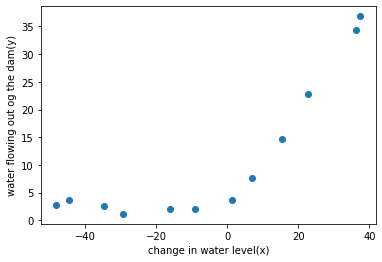

In [58]:
plot_data()

# 2. Model Implementation

### 2.1 Cost Function
$$J(\theta) = \frac{1}{2m}\sum^m_{i =1}{X@theta -y} + \frac{1}{2m} *y$$

In [81]:
def costFunc(theta,X,y,Lambda):
    #be careful the shape of y, which should be 1-d array
    m=len(X)
    cost = 1/(2*m) * np.sum(pow((X@theta - y.flatten()),2))
    reg = Lambda/(2*m) *( theta[1:]@theta[1:])
    return cost+reg

In [82]:
theta = np.ones(X_train.shape[1],)
Lambda = 1
costFunc(theta,X_train,y_train,Lambda)

303.9931922202643

### 2.2 Gradient Vector
$$ \frac{\partial J(\theta)}{\partial \theta_j}= (\frac{1}{m} \sum_{i=1}^m (X@ \theta - y)x^{(i)}_j) + \frac{\lambda}{m} \theta_j$$

In [93]:
def gradient_reg(theta,X,y,Lambda):
    grad = (X@theta -y.flatten())@ X
    reg = Lambda * theta
    reg[0] = 0
    return (grad+reg)/(len(X))

In [94]:
gradient_reg(theta,X_train,y_train,Lambda =1)

array([-15.30301567, 598.25074417])

### 2.3 Gradient Descent with TNC

In [95]:
def train_model(X,y,Lambda):
    theta = np.ones(X.shape[1])
    res = minimize(fun = costFunc,
                  x0 = theta,
                  args = (X,y,Lambda),
                  method = "TNC",
                  jac =gradient_reg)
    
    return res.x

In [96]:
theta_final = train_model(X_train,y_train,Lambda = 0)
theta_final

array([13.08790348,  0.36777923])

# 3. Model Evaluation

### 3.1 Hypothesis on training set

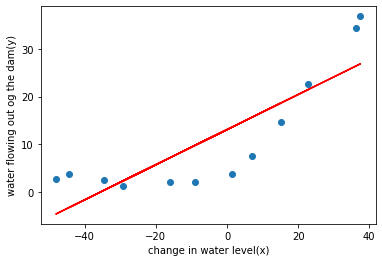

In [97]:
plot_data()
plt.plot(X_train[:,1],X_train@theta_final, c = "r")

### 3.2 Training cost curve and CV cost curve
Now let's see how the traning cost and cross validation cost will be with the increase of number of samples

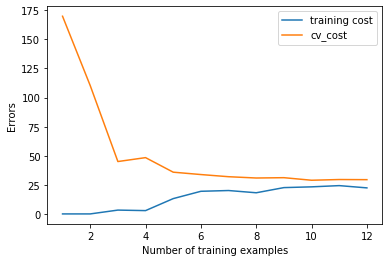

In [128]:
def plot_learning_curve(X_train,y_train,X_val,y_val,Lambda):
    """This function will plot learning curve, with the increase training samples"""
    n= range(1,len(X_train)+1) # the increasing number of samples 
    training_costs = []
    cv_costs = []
    
    for i in n:
        res = train_model(X_train[:i,:],y_train[:i,:],Lambda)
        training_cost_i =costFunc(res,X_train[:i,:],y_train[:i,:],Lambda)
        cv_cost_i = costFunc(res,X_val,y_val,Lambda)
        training_costs.append(training_cost_i)
        cv_costs.append(cv_cost_i)
        
    # visualize two cost curves
    plt.plot(n,training_costs,label  ="training cost")
    plt.plot(n,cv_costs,label = "cv_cost")
    plt.legend()
    plt.xlabel("Number of training examples")
    plt.ylabel("Errors")
    plt.show()
    
plot_learning_curve(X_train,y_train,X_val,y_val,Lambda=0)

As we can see, both the cost of training samples and cross validation are high, meaning it is a high bias model(underfitting issue). There are several ways to address this issue:
<li>more features -- no more features we can use</li>
<li>more polynomial terms -- only options we can do</li>
<li>reduce lambda -- we didn't use any lambda at all</li>

### feature mapping
Add ploynomial terms to better divide our data

In [129]:
def poly_feature(X,power):
    for i in range(2,power +1):
        X= np.insert(X,X.shape[1],np.power(X[:,1],i),axis = 1) #always add a ploynomial term at the end, based on the first feature( not bais unit)
        return X

### Normalization
Since we are generating ploynomial terms, we'd better normalize our data here,to enhance convergence speed and accuracy. Because these high ploynomial terms will make your columns very different.

In [131]:
def get_means_stds(X):
    means = np.mean(X,axis = 0)
    stds = np.std(X,axis =0)
    return means, stds

def feature_normalize(X,means,stds):
    # Don't normalize the ones term, as you denominator will be 0
    X[:,1:] = (X[:,1:] - means[1:])/stds[1:]  
    return X

In [142]:
power = 6
X_train_poly = poly_feature(X_train,power)
X_val_poly = poly_feature(X_val,power)
X_test_poly = poly_feature(X_test,power)

In [143]:
train_means, train_stds = get_means_stds(X_train_poly)

In [174]:
X_train_norm = feature_normalize(X_train_poly,train_means,train_stds)
X_val_norm = feature_normalize(X_val_poly,train_means,train_stds)
X_test_norm = feature_normalize(X_test_poly,train_means,train_stds)

In [168]:
theta_fit =train_model(X_train_norm,y_train,Lambda = 0)
print("Final theta:", theta_fit)

Final theta: [11.21759019 13.34694925  7.10824866]


In [169]:
def plot_poly_fit():
    plot_data()
    
    # generate some points to plot hypothesis
    x = np.linspace(-60,60,100)
    xx = x.reshape(100,1)
    xx = np.insert(xx,0,1,axis=1)
    xx = poly_feature(xx,power)
    xx = feature_normalize(xx,train_means,train_stds)
    
    plt.plot(x,xx@theta_fit,"r--")

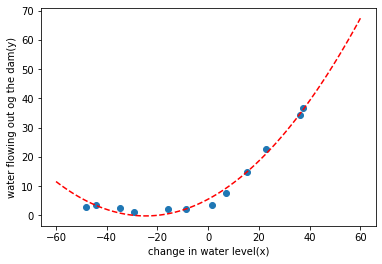

In [170]:
plot_poly_fit()

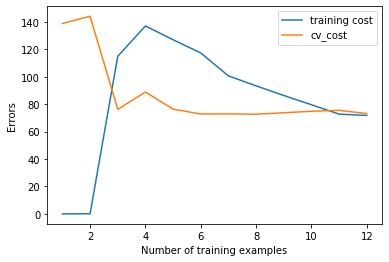

In [171]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,Lambda = 100)

In [172]:
Lambdas = [0, 0.001, 0.003, 0.01, 0.03, 1, 3, 10]
training_costs=[]
cv_costs=[]
for Lambda in Lambdas:
    res = train_model(X_train_norm,y_train,Lambda)
    #Lambda will be used only in training part, so make sure it is 0 in evaluation 
    tc = costFunc(res,X_train_norm,y_train,Lambda = 0)
    cv = costFunc(res,X_val_norm,y_val, Lambda = 0)
    
    training_costs.append(tc)
    cv_costs.append(cv)

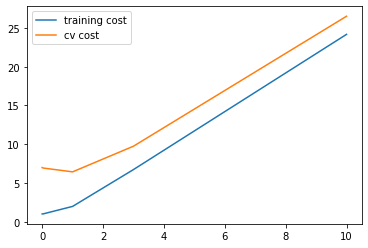

In [173]:
plt.plot(Lambdas, training_costs, label = "training cost")
plt.plot(Lambdas, cv_costs, label= "cv cost")
plt.legend()

plt.show()

In [159]:
best_Lambda = Lambdas[np.argmin(cv_costs)]

In [123]:
res = train_model(X_train_norm, y_train,Lambda =best_Lambda)

In [125]:
test_cost = costFunc(res,X_test_norm,y_test,Lambda = 0)
print(test_cost)

8.955070490818965
